# Regularyzacja w modelu regresji - wstęp

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$.
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` z `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [2]:
#generujemy dane
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + stats.norm.rvs(size=n, loc=2, scale=2)

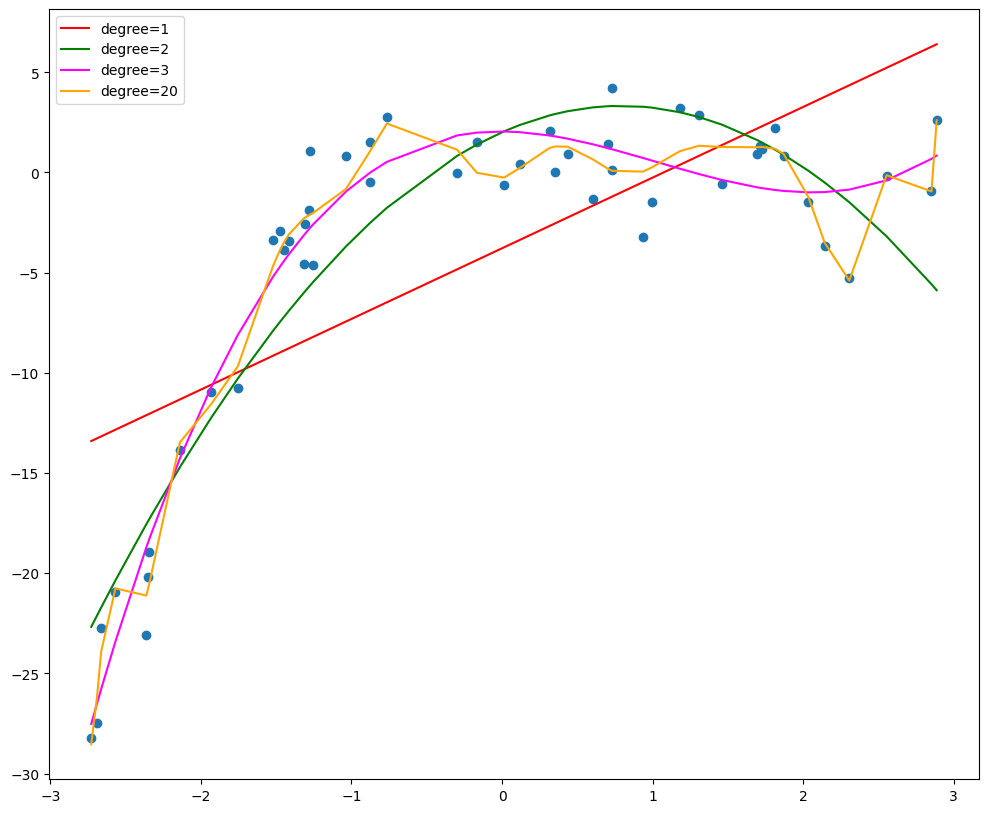

In [3]:
#rysujemy dopasowanie dla modeli wielomianowych o rzędzie wielomianu równym: 1, 2, 3 i 20
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = OLS(endog=y, exog=X).fit()

    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanej pary punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [4]:
# Rigde - powinno wygładzać wielomian (zwalczamy problem przeuczenia modelu)
# Sposob I
X = x.reshape(-1, 1)
polynomial_features_20 = PolynomialFeatures(degree=20,include_bias = False)
X20 = polynomial_features_20.fit_transform(X)

In [5]:
X20.shape

(50, 20)

In [6]:
X20

array([[-2.72775994e+00,  7.44067431e+00, -2.02963733e+01,
         5.53636342e+01, -1.51018704e+02,  4.11942771e+02,
        -1.12368099e+03,  3.06513199e+03, -8.36094427e+03,
         2.28066489e+04, -6.22110632e+04,  1.69696846e+05,
        -4.62892260e+05,  1.26265897e+06, -3.44423055e+06,
         9.39503413e+06, -2.56273978e+07,  6.99053891e+07,
        -1.90685120e+08,  5.20143233e+08],
       [-1.41545084e+00,  2.00350107e+00, -2.83585726e+00,
         4.01401653e+00, -5.68164306e+00,  8.04208641e+00,
        -1.13831779e+01,  1.61123287e+01, -2.28062092e+01,
         3.22810678e+01, -4.56922644e+01,  6.46751539e+01,
        -9.15445006e+01,  1.29576740e+02, -1.83409505e+02,
         2.59607137e+02, -3.67461139e+02,  5.20123177e+02,
        -7.36208785e+02,  1.04206734e+03],
       [-8.76221719e-01,  7.67764501e-01, -6.72731930e-01,
         5.89462328e-01, -5.16499695e-01,  4.52568250e-01,
        -3.96550130e-01,  3.47465837e-01, -3.04457113e-01,
         2.66771934e-01, -2.3

In [7]:
X20_scale = StandardScaler().fit_transform(X20) # (x - mean) / std (aby móc użyć Ridge lub Lasso najpierw trzeba zeskalować kolumny X)
X20_scale

array([[-1.56660051e+00,  1.92581533e+00, -2.18680420e+00,
         2.21905077e+00, -2.41587677e+00,  2.29961784e+00,
        -2.47442792e+00,  2.27195371e+00, -2.44532102e+00,
         2.18183927e+00, -2.36561333e+00,  2.05581758e+00,
        -2.25606213e+00,  1.91067529e+00, -2.12981395e+00,
         1.75735267e+00, -1.99567484e+00,  1.60303261e+00,
        -1.85965182e+00,  1.45237820e+00],
       [-7.76053952e-01, -3.16901556e-01, -2.46537757e-01,
        -5.06750941e-01, -4.58025462e-02, -5.10048211e-01,
        -7.65747639e-04, -4.70022278e-01, -5.58540970e-03,
        -4.28198844e-01, -2.37802769e-02, -3.92949026e-01,
        -4.41065491e-02, -3.64320797e-01, -6.32866703e-02,
        -3.40940716e-01, -8.04798948e-02, -3.21562823e-01,
        -9.55940323e-02, -3.05270594e-01],
       [-4.51217586e-01, -8.26616282e-01, -6.16459288e-03,
        -6.88537215e-01,  3.84276777e-02, -5.62843397e-01,
         2.36676418e-02, -4.84199581e-01,  9.98593273e-04,
        -4.31867817e-01, -2.2

In [8]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y) #definiujemy Ridge z zadanym parametrem i od razu dopasowujemy do zeskalowanych danych
ridge01

Ridge(alpha=0.1)

In [9]:
#żeby porównanie było fair z ridge robimy to na zeskalowanych danych
lm =  LinearRegression().fit(X20_scale,y)

In [10]:
print(ridge01.coef_) # [b1, b2, ..., b20] w ridge (bez wyrazu wolnego)
print(lm.coef_) # [b1, b2, ..., b20] w zwykłym lm (bez wyrazu wolnego)


[-0.29505016 -0.79674853  7.5401118  -6.95400968  0.63912003 -2.74585894
 -1.83177967  1.31128679 -1.73450256  3.17705026 -0.96425635  3.11278533
 -0.18237913  1.87262976  0.49993898  0.13668333  1.12931313 -1.6191397
  1.76677062 -3.11016208]
[ 4.05604041e+00  5.16228617e+01 -3.02843590e+02 -1.17990178e+03
  5.07104158e+03  1.06977232e+04 -3.93439024e+04 -5.11975169e+04
  1.72054469e+05  1.39627640e+05 -4.52797706e+05 -2.17882183e+05
  7.30374062e+05  1.76173637e+05 -7.06198279e+05 -3.99030585e+04
  3.75606621e+05 -3.45286844e+04 -8.44797613e+04  1.81540732e+04]


In [11]:
print(ridge01.intercept_)
print(lm.intercept_)
# wyrazy wolne poszczególnych metod

-4.232957269967636
-4.232957269979417


In [12]:
ridge01_params = [ridge01.intercept_] + list(ridge01.coef_[1:])
ridge01_params # wyraz wolny i wspolczynniki regresji grzbietowej

[-4.232957269967636,
 -0.7967485331867572,
 7.540111803575754,
 -6.954009677400669,
 0.6391200340781015,
 -2.7458589417751145,
 -1.831779673967414,
 1.3112867899690857,
 -1.7345025596188157,
 3.1770502569997716,
 -0.9642563476535558,
 3.112785332636701,
 -0.1823791303217558,
 1.8726297601140098,
 0.49993898218868776,
 0.13668332638322897,
 1.1293131309047997,
 -1.6191397008942678,
 1.7667706247632955,
 -3.110162075236972]

In [13]:
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params))
ridge01_r2 = ridge01.score(X20_scale, y)
print("R2: {}".format(ridge01_r2))

Współczynniki regresji z regularyzacja Ridge: [-4.232957269967636, -0.7967485331867572, 7.540111803575754, -6.954009677400669, 0.6391200340781015, -2.7458589417751145, -1.831779673967414, 1.3112867899690857, -1.7345025596188157, 3.1770502569997716, -0.9642563476535558, 3.112785332636701, -0.1823791303217558, 1.8726297601140098, 0.49993898218868776, 0.13668332638322897, 1.1293131309047997, -1.6191397008942678, 1.7667706247632955, -3.110162075236972]
R2: 0.9549938419188667


In [14]:
#dla porównania regresja zwykła
lm_r2 = lm.score(X20_scale, y)
print("R2: {}".format(lm_r2))
#nieco wyżej, ale to na zb. treningowym, więc nic dziwnego

R2: 0.9730158050454788


In [15]:
## Sposob 2 - pipeline

ridge01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Ridge(alpha=0.1)
)
ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [16]:
ridge01_pipeline['ridge']

Ridge(alpha=0.1)

In [17]:
ridge01_params = [ridge01_pipeline['ridge'].intercept_] + list(ridge01_pipeline['ridge'].coef_[1:])
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params)) #współczynniki
ridge01_r2 = ridge01_pipeline['ridge'].score(X20_scale, y)
print("R2: {}".format(ridge01_r2)) #R^2

Współczynniki regresji z regularyzacja Ridge: [-4.232957269967636, -0.7967485331867572, 7.540111803575754, -6.954009677400669, 0.6391200340781015, -2.7458589417751145, -1.831779673967414, 1.3112867899690857, -1.7345025596188157, 3.1770502569997716, -0.9642563476535558, 3.112785332636701, -0.1823791303217558, 1.8726297601140098, 0.49993898218868776, 0.13668332638322897, 1.1293131309047997, -1.6191397008942678, 1.7667706247632955, -3.110162075236972]
R2: 0.9549938419188667


In [18]:
ridge01.predict(X20_scale) #wartości dopasowane

array([-27.20535303,  -3.42322192,   0.07107096,   1.44744696,
       -19.69902993,   0.39909035,  -2.17327423,   0.78039719,
        -2.40787266,  -0.91167192,   0.89451891, -15.26432573,
       -23.26692218,   0.33616667,   0.93677923, -11.11308672,
         0.95936105,   0.875702  ,   0.06244759, -19.32209433,
         0.87584353, -19.51446502,   0.91063019,   0.87351247,
       -25.95342475,  -2.79791656,  -1.50439525,   0.78573191,
        -1.97048565,   0.9580603 ,  -2.48493279,   0.91763752,
        -0.16686933,   0.30685561,   0.88799702,   0.88757155,
         0.87671373,  -4.09204899,   0.86869333,  -2.37747967,
        -7.94340688, -25.21016033,  -0.59429573,  -3.74690008,
         0.97698081,   0.39669766,  -4.61316873,   0.90281657,
        -2.12355518,   0.04377101])

In [19]:
ridge01_fittedvalues = ridge01_pipeline.predict(X) #wartości dopasowane obliczone za pomocą pipeline'a
ridge01_fittedvalues
#to samo co wcześniej - metody są równoważne

array([-27.20535303,  -3.42322192,   0.07107096,   1.44744696,
       -19.69902993,   0.39909035,  -2.17327423,   0.78039719,
        -2.40787266,  -0.91167192,   0.89451891, -15.26432573,
       -23.26692218,   0.33616667,   0.93677923, -11.11308672,
         0.95936105,   0.875702  ,   0.06244759, -19.32209433,
         0.87584353, -19.51446502,   0.91063019,   0.87351247,
       -25.95342475,  -2.79791656,  -1.50439525,   0.78573191,
        -1.97048565,   0.9580603 ,  -2.48493279,   0.91763752,
        -0.16686933,   0.30685561,   0.88799702,   0.88757155,
         0.87671373,  -4.09204899,   0.86869333,  -2.37747967,
        -7.94340688, -25.21016033,  -0.59429573,  -3.74690008,
         0.97698081,   0.39669766,  -4.61316873,   0.90281657,
        -2.12355518,   0.04377101])

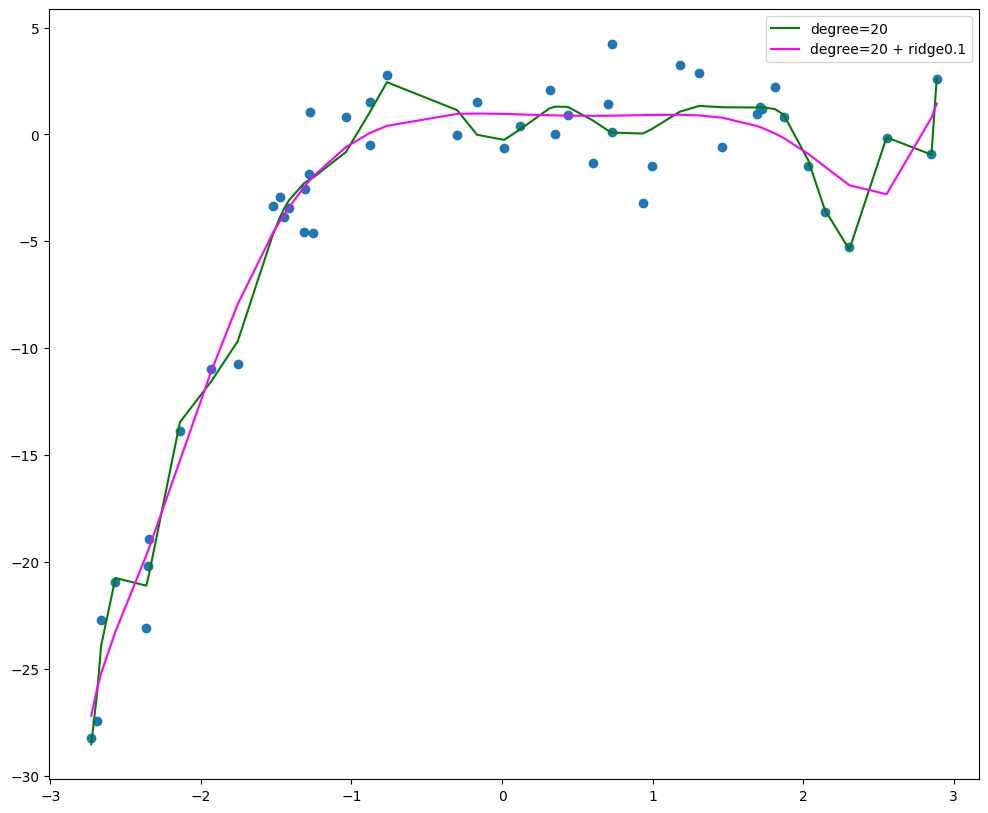

In [20]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()#jeśli chodzi o watości dopasowane, nie jest ważne, czy dopasowujemy model na zeskalowanych X-ach czy nie

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))


plt.legend()
#widzimy, że ridge się nie przeuczyło

In [21]:
#teraz pipeline dla lasso
lasso01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10000)
)
lasso01_pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=20, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=10000))])

In [22]:
lasso01_params = [lasso01_pipeline['lasso'].intercept_] + list(lasso01_pipeline['lasso'].coef_[1:])
print("Współczynniki regresji z regularyzacja Lasso: {}".format(lasso01_params))
lasso01_r2 = lasso01_pipeline.score(X, y)
print("R2: {}".format(lasso01_r2))

Współczynniki regresji z regularyzacja Lasso: [-4.2329572699676365, -3.344948582040861, 5.74253735806934, -2.204635603221387, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6669189016020481]
R2: 0.943953240784273


In [23]:
lasso01_fittedvalues = lasso01_pipeline.predict(X) #wartości dopasowane

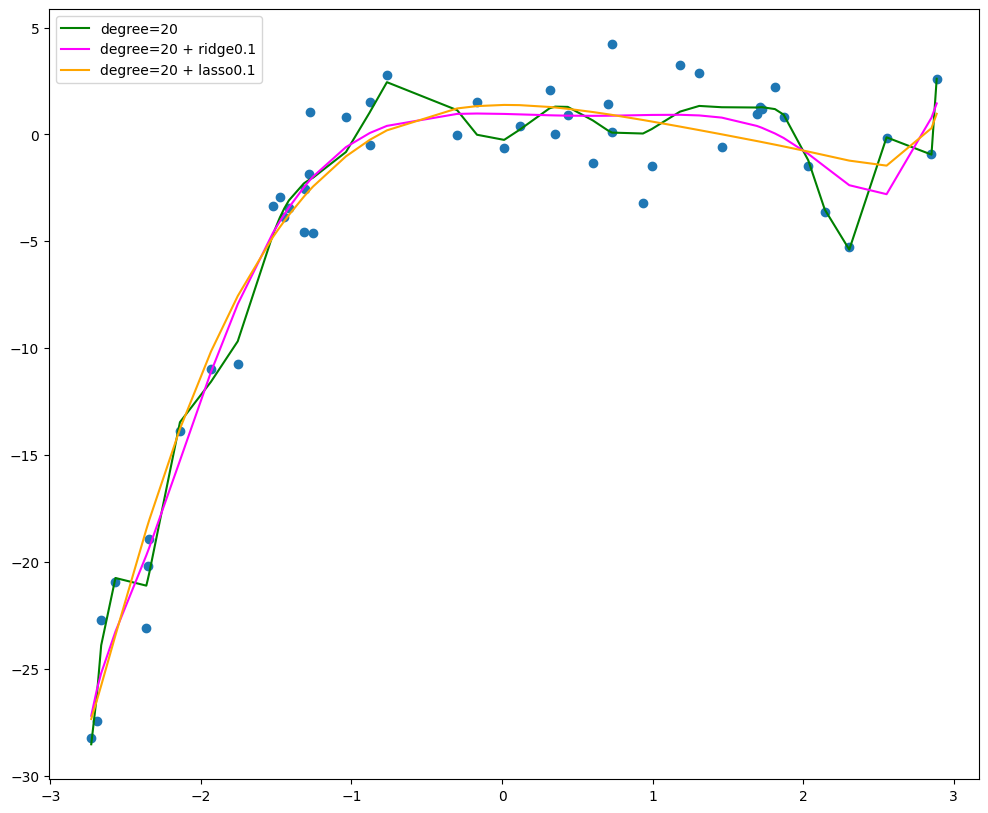

In [24]:
#wykres dopasowania dla regresji wielomianowej bez kary, z karą ridge i z karą lasso
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()

#widzimy, że i ridge i lasso się nie przeuczyło

# Zadanie 2

Narysuj wykres funkcji
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianej stopnia 2, 10 i 20,
- wielomianej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

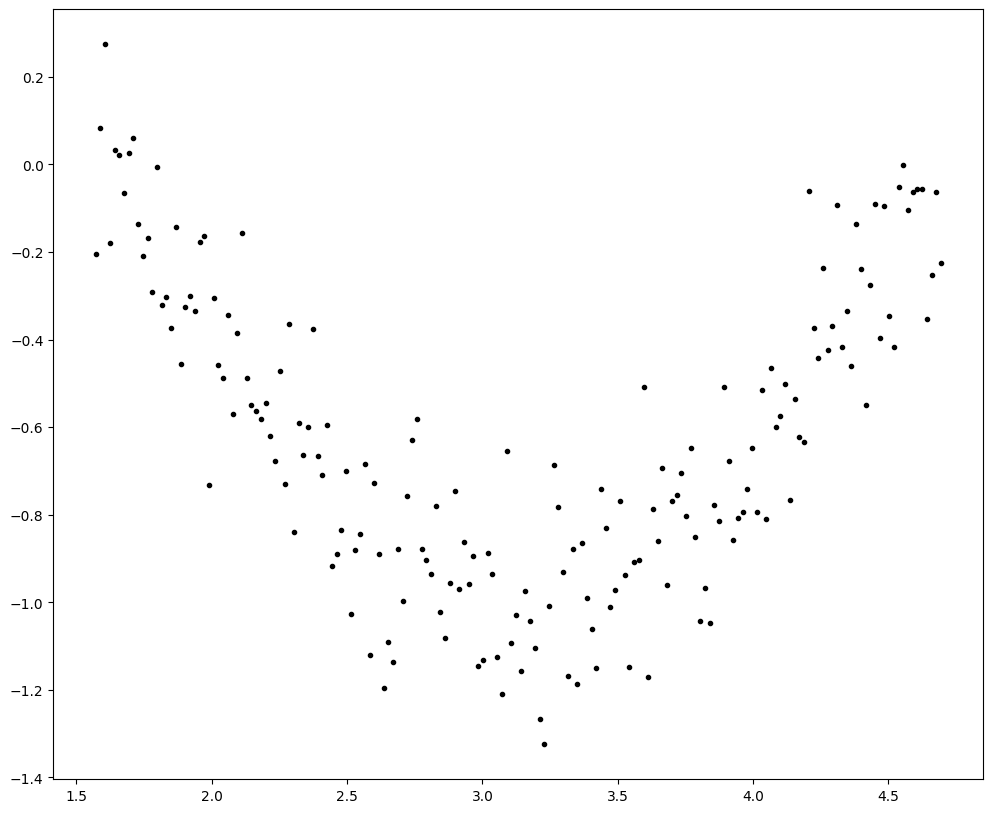

In [25]:
#generacja danych
x = np.array([i*np.pi/180 for i in range(90,270,1)])
X = pd.DataFrame(x)
y = np.cos(x)+np.random.normal(0,0.15,len(x))
plt.plot(x,y,'.',color = 'black')

In [26]:
#funkcja dopasowywująca modele, które nas interesują
def fit_model(X,y,model,power):
  new_model = make_pipeline(
      PolynomialFeatures(degree = power,include_bias = False),
      StandardScaler(),
      model
  )
  new_model.fit(X,y)
  return(new_model.predict(X))

In [27]:
#tworzymy modele
models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [28]:
#definiujemy miarę RSS (czyli właściwie MSE razy liczba obserwacji)
def rss_fun(y,y_pred):
  return(sum((y-y_pred)**2))

In [29]:
#liczymy RSS dla każdego modelu na danych na których uczyliśmy model
y_pred_dict = {}
rss = {}
for key,values in zip(models,models.values()):
  y_pred = fit_model(X,y,values['model'],values['power'])
  y_pred_dict[key] = y_pred
  rss[key] = rss_fun(y_pred,y)

In [30]:
pd.DataFrame(list(rss.items()),columns = ['Model','RSS'])
#nie dziwi, że RSS najmniejsze dla regresji wielomianu 20 stopnia, bo ten model najlepiej dopasuje się do danych na których był uczony,
#ale na innym zbiorze danych już pewnie taki nie będzie (overfitting)

,Model,RSS
0,linear_regression,22.031092
1,polynomial_regression2,4.410429
2,polynomial_regression10,4.165886
3,polynomial_regression20,3.875152
4,ridge_regression_0.1,4.237846
5,lasso_regression_0.1,19.347338


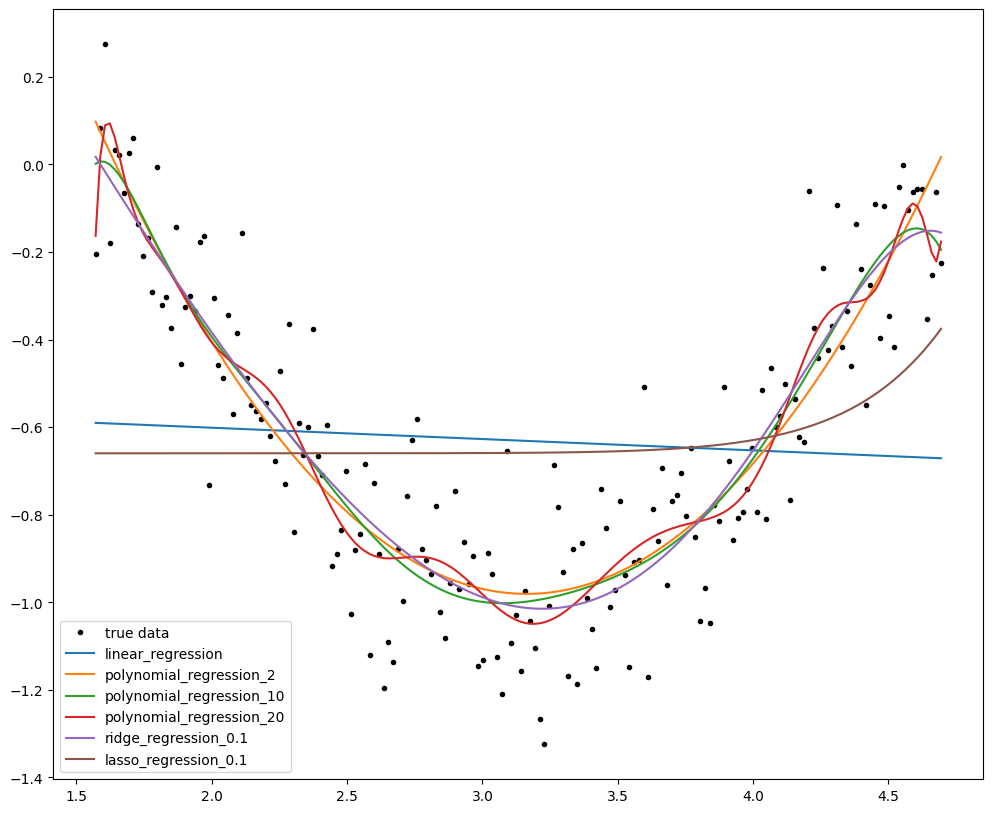

In [31]:
rcParams['figure.figsize'] = 12, 10

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2',
                          'polynomial_regression_10', 'polynomial_regression_20',
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")
for y_pred in y_pred_dict.values():
    plt.plot(x, y_pred)
plt.legend(labels)

#polynomial 20 przeuczony, ridge z alpha = 0.1 ok, lasso z alpha = 0.1 niedouczony - potrzebna mniejsza alpha